In [1]:
# Cell 1: Environment Setup and Data Download
!mkdir -p ~/.kaggle
# Make sure you have uploaded your kaggle.json file before running this in Colab
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/drive-digital-retinal-images-for-vessel-extraction
!unzip -q drive-digital-retinal-images-for-vessel-extraction.zip -d drive_dataset

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction
License(s): other
  0% 0.00/28.0M [00:00<?, ?B/s]
100% 28.0M/28.0M [00:00<00:00, 1.42GB/s]


In [2]:
# Cell 2: Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from PIL import Image
from skimage.filters import threshold_niblack, threshold_sauvola
from skimage.morphology import remove_small_objects

# Set random seed for reproducibility if needed later
np.random.seed(42)

In [3]:
# Cell 3: Evaluation Metrics Definition
def calculate_metrics(pred_mask, gt_mask, fov_mask):
    """
    Calculates metrics only within the Field of View (FOV) to prevent
    background pixels from artificially inflating the accuracy.
    """
    # Flatten arrays and restrict to FOV
    valid_pixels = fov_mask > 0
    y_pred = pred_mask[valid_pixels] > 0
    y_true = gt_mask[valid_pixels] > 0

    TP = np.sum(y_pred & y_true)
    TN = np.sum((~y_pred) & (~y_true))
    FP = np.sum(y_pred & (~y_true))
    FN = np.sum((~y_pred) & y_true)

    # Add a small epsilon (1e-8) to avoid division by zero
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    f1_score = 2 * precision * sensitivity / (precision + sensitivity + 1e-8)

    return accuracy, sensitivity, specificity, f1_score

In [11]:
# Cell 4: Processing Pipeline (Focus on Thin Vessels)
image_paths = sorted(glob.glob('./drive_dataset/**/images/*.tif', recursive=True))

results = []
# Initialize variables to None
sample_img, sample_gt_thin, sample_nib, sample_sau = None, None, None, None

for i, img_path in enumerate(image_paths):
    filename = os.path.basename(img_path)
    prefix = filename[:2]

    # 1. Load Data
    img = cv2.imread(img_path)
    green_channel = img[:, :, 1]

    mask_dir = os.path.dirname(img_path).replace('images', 'mask')
    mask_path = glob.glob(os.path.join(mask_dir, f"{prefix}*.gif"))[0]
    fov_mask = np.array(Image.open(mask_path).convert('L'))
    if fov_mask.shape != green_channel.shape:
        fov_mask = cv2.resize(fov_mask, (green_channel.shape[1], green_channel.shape[0]))

    gt_dir = os.path.dirname(img_path).replace('images', '1st_manual')
    gt_files = glob.glob(os.path.join(gt_dir, f"{prefix}*.gif"))
    if not gt_files:
        continue # Skips if no GT found

    gt_mask = np.array(Image.open(gt_files[0]).convert('L'))

    # 2. Preprocessing
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_green = clahe.apply(green_channel)

    # 3. Local Thresholding
    window_size = 25
    k_val = 0.1

    thresh_nib = threshold_niblack(enhanced_green, window_size=window_size, k=k_val)
    bin_nib = (enhanced_green < thresh_nib).astype(np.uint8) * 255

    thresh_sau = threshold_sauvola(enhanced_green, window_size=window_size, k=k_val)
    bin_sau = (enhanced_green < thresh_sau).astype(np.uint8) * 255

    # 4. Post-processing & Cleanup
    bin_nib = remove_small_objects(bin_nib > 0, min_size=30).astype(np.uint8) * 255

    bin_sau = remove_small_objects(bin_sau > 0, min_size=20).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    bin_sau = cv2.morphologyEx(bin_sau, cv2.MORPH_CLOSE, kernel)

    bin_nib = cv2.bitwise_and(bin_nib, bin_nib, mask=fov_mask)
    bin_sau = cv2.bitwise_and(bin_sau, bin_sau, mask=fov_mask)

    # --- 5. NEW: ISOLATE THIN VESSELS IN GROUND TRUTH ---
    thick_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    # Opening removes thin lines, leaving only thick ones
    gt_thick = cv2.morphologyEx(gt_mask, cv2.MORPH_OPEN, thick_kernel)
    # Subtract thick vessels to get purely thin ones
    gt_thin = cv2.subtract(gt_mask, gt_thick)

    # Capture the first successful run for the visualization block
    if sample_img is None:
        sample_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sample_gt_thin = gt_thin.copy() # Saving the THIN ground truth
        sample_nib = bin_nib.copy()
        sample_sau = bin_sau.copy()
        print(f"Captured sample image for visualization: {filename}")

    # 6. Evaluate strictly against the THIN ground truth
    acc_n, sens_n, spec_n, f1_n = calculate_metrics(bin_nib, gt_thin, fov_mask)
    acc_s, sens_s, spec_s, f1_s = calculate_metrics(bin_sau, gt_thin, fov_mask)

    results.append({"Method": "Niblack", "Accuracy": acc_n, "Sensitivity": sens_n, "Specificity": spec_n, "F1-Score": f1_n})
    results.append({"Method": "Sauvola", "Accuracy": acc_s, "Sensitivity": sens_s, "Specificity": spec_s, "F1-Score": f1_s})

print(f"Processing Complete. Processed {len(results)//2} images.")

Captured sample image for visualization: 21_training.tif
Processing Complete. Processed 20 images.


In [12]:
# Cell 5: Display Average Metrics
df = pd.DataFrame(results)

print("=== FINAL EVALUATION METRICS (Averaged across dataset) ===")
summary_df = df.groupby("Method").mean().round(4)
display(summary_df) # Use display() for a nice HTML table rendering in Jupyter/Colab

=== FINAL EVALUATION METRICS (Averaged across dataset) ===


,Accuracy,Sensitivity,Specificity,F1-Score
Method,,,,
Niblack,0.7513,0.8224,0.7441,0.3853
Sauvola,0.8932,0.6549,0.9183,0.5407


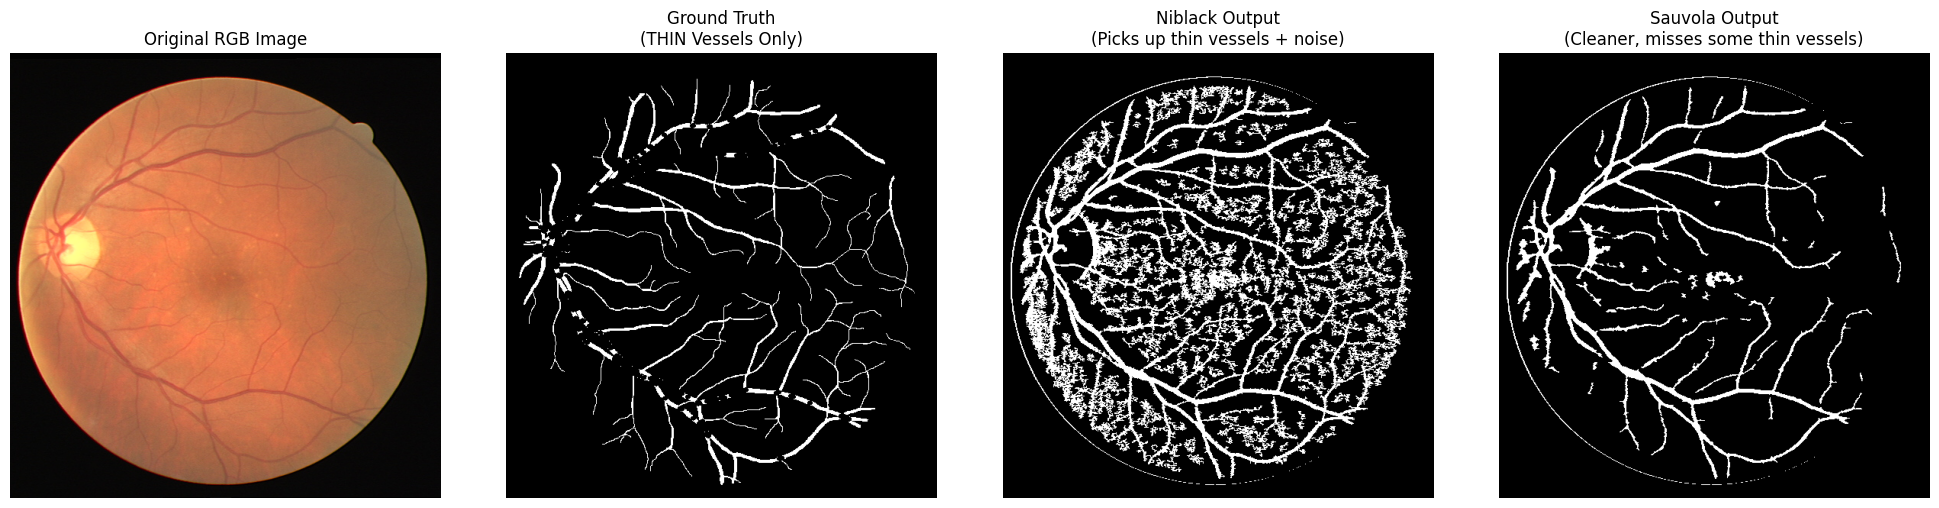

In [13]:
# Cell 6: Visual Comparison (Thin Vessel Focus)
if sample_img is not None:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(sample_img)
    axes[0].set_title("Original RGB Image")
    axes[0].axis('off')

    axes[1].imshow(sample_gt_thin, cmap='gray')
    axes[1].set_title("Ground Truth\n(THIN Vessels Only)")
    axes[1].axis('off')

    axes[2].imshow(sample_nib, cmap='gray')
    axes[2].set_title("Niblack Output\n(Picks up thin vessels + noise)")
    axes[2].axis('off')

    axes[3].imshow(sample_sau, cmap='gray')
    axes[3].set_title("Sauvola Output\n(Cleaner, misses some thin vessels)")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("ERROR: No images were captured for visualization. Check if the dataset paths are correct and '1st_manual' folders contain the .gif files.")